<a href="https://colab.research.google.com/github/MiniSoda17/comp3710-deep-learning/blob/main/COMP3710_Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.3 DawnBench


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# CIFAR-10 transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

# Datasets + Dataloaders
batch_size = 512
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_classes = len(classes)

100%|██████████| 170M/170M [00:14<00:00, 11.5MB/s]


In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = None
        if stride != 1 or in_planes != planes:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)
    def _make_layer(self, planes, blocks, stride):
        layers = []
        layers.append(BasicBlock(self.in_planes, planes, stride))
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_planes, planes))
        return nn.Sequential(*layers)
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


In [ ]:
model = ResNet18(num_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, epochs=50, steps_per_epoch=len(trainloader)
)
scaler = GradScaler()

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss/len(trainloader))

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.2f}%")

torch.save(model.state_dict(), "/content/drive/MyDrive/resnet18_cifar10.pth")
print("Target reached. Model saved!")



/tmp/ipython-input-1563024922.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/50:   0%|          | 0/98 [00:00<?, ?it/s]/tmp/ipython-input-1563024922.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50: 100%|██████████| 98/98 [00:07<00:00, 13.24it/s, loss=1.5]
/tmp/ipython-input-1563024922.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50], Accuracy: 50.79%


Epoch 2/50: 100%|██████████| 98/98 [00:07<00:00, 13.29it/s, loss=1.08]


Epoch [2/50], Accuracy: 60.65%


Epoch 3/50: 100%|██████████| 98/98 [00:07<00:00, 13.38it/s, loss=0.864]


Epoch [3/50], Accuracy: 66.78%


Epoch 4/50: 100%|██████████| 98/98 [00:07<00:00, 13.18it/s, loss=0.719]


Epoch [4/50], Accuracy: 71.86%


Epoch 5/50: 100%|██████████| 98/98 [00:07<00:00, 13.18it/s, loss=0.622]


Epoch [5/50], Accuracy: 72.42%


Epoch 6/50: 100%|██████████| 98/98 [00:07<00:00, 13.08it/s, loss=0.579]


Epoch [6/50], Accuracy: 73.48%


Epoch 7/50: 100%|██████████| 98/98 [00:07<00:00, 13.04it/s, loss=0.522]


Epoch [7/50], Accuracy: 74.56%


Epoch 8/50: 100%|██████████| 98/98 [00:07<00:00, 13.15it/s, loss=0.463]


Epoch [8/50], Accuracy: 76.74%


Epoch 9/50: 100%|██████████| 98/98 [00:07<00:00, 13.05it/s, loss=0.437]


Epoch [9/50], Accuracy: 77.37%


Epoch 10/50: 100%|██████████| 98/98 [00:07<00:00, 13.02it/s, loss=0.399]


Epoch [10/50], Accuracy: 72.45%


Epoch 11/50: 100%|██████████| 98/98 [00:07<00:00, 12.99it/s, loss=0.381]


Epoch [11/50], Accuracy: 79.93%


Epoch 12/50: 100%|██████████| 98/98 [00:07<00:00, 13.07it/s, loss=0.339]


Epoch [12/50], Accuracy: 82.25%


Epoch 13/50: 100%|██████████| 98/98 [00:07<00:00, 13.42it/s, loss=0.32]


Epoch [13/50], Accuracy: 84.06%


Epoch 14/50: 100%|██████████| 98/98 [00:07<00:00, 13.22it/s, loss=0.288]


Epoch [14/50], Accuracy: 80.61%


Epoch 15/50: 100%|██████████| 98/98 [00:07<00:00, 13.08it/s, loss=0.264]


Epoch [15/50], Accuracy: 82.66%


Epoch 16/50: 100%|██████████| 98/98 [00:07<00:00, 12.88it/s, loss=0.248]


Epoch [16/50], Accuracy: 85.95%


Epoch 17/50: 100%|██████████| 98/98 [00:07<00:00, 13.41it/s, loss=0.226]


Epoch [17/50], Accuracy: 84.52%


Epoch 18/50: 100%|██████████| 98/98 [00:07<00:00, 12.62it/s, loss=0.205]


Epoch [18/50], Accuracy: 87.83%


Epoch 19/50: 100%|██████████| 98/98 [00:07<00:00, 13.47it/s, loss=0.189]


Epoch [19/50], Accuracy: 86.80%


Epoch 20/50: 100%|██████████| 98/98 [00:07<00:00, 13.31it/s, loss=0.171]


Epoch [20/50], Accuracy: 87.44%


Epoch 21/50: 100%|██████████| 98/98 [00:07<00:00, 13.15it/s, loss=0.161]


Epoch [21/50], Accuracy: 88.15%


Epoch 22/50: 100%|██████████| 98/98 [00:07<00:00, 13.34it/s, loss=0.151]


Epoch [22/50], Accuracy: 89.76%


Epoch 23/50: 100%|██████████| 98/98 [00:07<00:00, 13.34it/s, loss=0.137]


Epoch [23/50], Accuracy: 90.19%


Epoch 24/50: 100%|██████████| 98/98 [00:07<00:00, 13.38it/s, loss=0.127]


Epoch [24/50], Accuracy: 89.41%


Epoch 25/50: 100%|██████████| 98/98 [00:07<00:00, 13.29it/s, loss=0.112]


Epoch [25/50], Accuracy: 90.09%


Epoch 26/50: 100%|██████████| 98/98 [00:07<00:00, 13.00it/s, loss=0.107]


Epoch [26/50], Accuracy: 90.50%


Epoch 27/50: 100%|██████████| 98/98 [00:07<00:00, 12.97it/s, loss=0.0999]


Epoch [27/50], Accuracy: 91.11%


Epoch 28/50: 100%|██████████| 98/98 [00:07<00:00, 13.13it/s, loss=0.0844]


Epoch [28/50], Accuracy: 90.72%


Epoch 29/50: 100%|██████████| 98/98 [00:07<00:00, 13.36it/s, loss=0.0777]


Epoch [29/50], Accuracy: 90.53%


Epoch 30/50: 100%|██████████| 98/98 [00:07<00:00, 13.31it/s, loss=0.0727]


Epoch [30/50], Accuracy: 91.05%


Epoch 31/50: 100%|██████████| 98/98 [00:07<00:00, 13.35it/s, loss=0.0609]


Epoch [31/50], Accuracy: 91.68%


Epoch 32/50: 100%|██████████| 98/98 [00:07<00:00, 13.20it/s, loss=0.0537]


Epoch [32/50], Accuracy: 91.84%


Epoch 33/50: 100%|██████████| 98/98 [00:07<00:00, 13.17it/s, loss=0.0457]


Epoch [33/50], Accuracy: 92.26%


Epoch 34/50: 100%|██████████| 98/98 [00:07<00:00, 13.38it/s, loss=0.0375]


Epoch [34/50], Accuracy: 91.83%


Epoch 35/50: 100%|██████████| 98/98 [00:07<00:00, 13.15it/s, loss=0.0325]


Epoch [35/50], Accuracy: 92.58%


Epoch 36/50: 100%|██████████| 98/98 [00:07<00:00, 13.42it/s, loss=0.0255]


Epoch [36/50], Accuracy: 92.43%


Epoch 37/50: 100%|██████████| 98/98 [00:07<00:00, 13.06it/s, loss=0.023]


Epoch [37/50], Accuracy: 92.90%


Epoch 38/50: 100%|██████████| 98/98 [00:07<00:00, 13.12it/s, loss=0.019]


Epoch [38/50], Accuracy: 93.10%


Epoch 39/50: 100%|██████████| 98/98 [00:07<00:00, 13.32it/s, loss=0.0146]


Epoch [39/50], Accuracy: 93.17%


Epoch 40/50: 100%|██████████| 98/98 [00:07<00:00, 12.99it/s, loss=0.0114]


Epoch [40/50], Accuracy: 93.13%


Epoch 41/50: 100%|██████████| 98/98 [00:07<00:00, 13.26it/s, loss=0.0083]


Epoch [41/50], Accuracy: 93.50%


Epoch 42/50: 100%|██████████| 98/98 [00:07<00:00, 13.18it/s, loss=0.00619]


Epoch [42/50], Accuracy: 93.53%


Epoch 43/50: 100%|██████████| 98/98 [00:07<00:00, 13.01it/s, loss=0.00483]


Epoch [43/50], Accuracy: 93.50%


Epoch 44/50: 100%|██████████| 98/98 [00:07<00:00, 13.20it/s, loss=0.00388]


Epoch [44/50], Accuracy: 93.59%


Epoch 45/50: 100%|██████████| 98/98 [00:07<00:00, 12.99it/s, loss=0.00412]


Epoch [45/50], Accuracy: 93.56%


Epoch 46/50: 100%|██████████| 98/98 [00:07<00:00, 13.34it/s, loss=0.00308]


Epoch [46/50], Accuracy: 93.67%


Epoch 47/50: 100%|██████████| 98/98 [00:07<00:00, 12.97it/s, loss=0.00285]


Epoch [47/50], Accuracy: 93.75%


Epoch 48/50: 100%|██████████| 98/98 [00:07<00:00, 13.31it/s, loss=0.00247]


Epoch [48/50], Accuracy: 93.82%


Epoch 49/50: 100%|██████████| 98/98 [00:07<00:00, 13.21it/s, loss=0.00194]


Epoch [49/50], Accuracy: 93.63%


Epoch 50/50: 100%|██████████| 98/98 [00:07<00:00, 12.92it/s, loss=0.00237]


Epoch [50/50], Accuracy: 93.80%
Target reached. Model saved!


In [ ]:
model = ResNet18(num_classes=n_classes).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/resnet18_cifar10.pth", map_location=device))
print("Pretrained model loaded!")


Pretrained model loaded!


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scaler = GradScaler()

num_epochs = 1  # demo only
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Demo Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss/len(trainloader))

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Demo Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.2f}%")


/tmp/ipython-input-3507590684.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Demo Epoch 1/1:   0%|          | 0/98 [00:00<?, ?it/s]/tmp/ipython-input-3507590684.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Demo Epoch 1/1: 100%|██████████| 98/98 [00:07<00:00, 13.25it/s, loss=0.0181]
/tmp/ipython-input-3507590684.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Demo Epoch [1/1], Accuracy: 92.19%


# 4.1 VAE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler

In [ ]:
class CNNVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 28 -> 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 14 -> 7
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # 7 -> 4
            nn.ReLU(),
            nn.Flatten(),
        )

        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 128*4*4)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # 4 -> 8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),   # 16 -> 32
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder_conv(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std if self.training else mu

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, 128, 4, 4)
        return self.decoder_conv(h)[:, :, :28, :28]  # crop to 28×28

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss averaged per pixel
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x, reduction="sum"
    ) / x.size(0)  # divide by batch size

    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)

    return BCE + beta * KLD, BCE, KLD



In [ ]:
# --- Data Loading ---
class OASISDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # The glob.glob function finds all files matching a pattern
        # The '**' and 'recursive=True' find images in all subdirectories
        self.file_paths = glob.glob(os.path.join(root_dir, '**', '*.png'), recursive=True)
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert('L') # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image

# Define transformations to resize and convert images to tensors
transformations = transforms.Compose([
    transforms.Resize((28, 28)), # Resize to 28x28
    transforms.ToTensor(),       # Convert to a PyTorch tensor (values between 0 and 1)
])

# Define paths on the Rangpur cluster
data_path = '/content/drive/My Drive/OASIS'
train_dir = os.path.join(data_path, 'keras_png_slices_train')
test_dir = os.path.join(data_path, 'keras_png_slices_test')

# Create a dataset and a data loader for the training data
train_dataset = OASISDataset(root_dir=train_dir, transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [ ]:
# --- Training Loop ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = CNNVAE(latent_dim=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 50 # Increase this for better results

print("Starting VAE training...")

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss, _, _ = vae_loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch: {epoch+1}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item() / len(data):.4f}')

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch: {epoch+1}, Average Loss: {avg_loss:.4f}')

print("Training complete.")
torch.save(model.state_dict(), 'vae_oasis.pth')

Using device: cuda
Starting VAE training...


KeyboardInterrupt: 

Generating latent space visualization by sampling with random background latents...


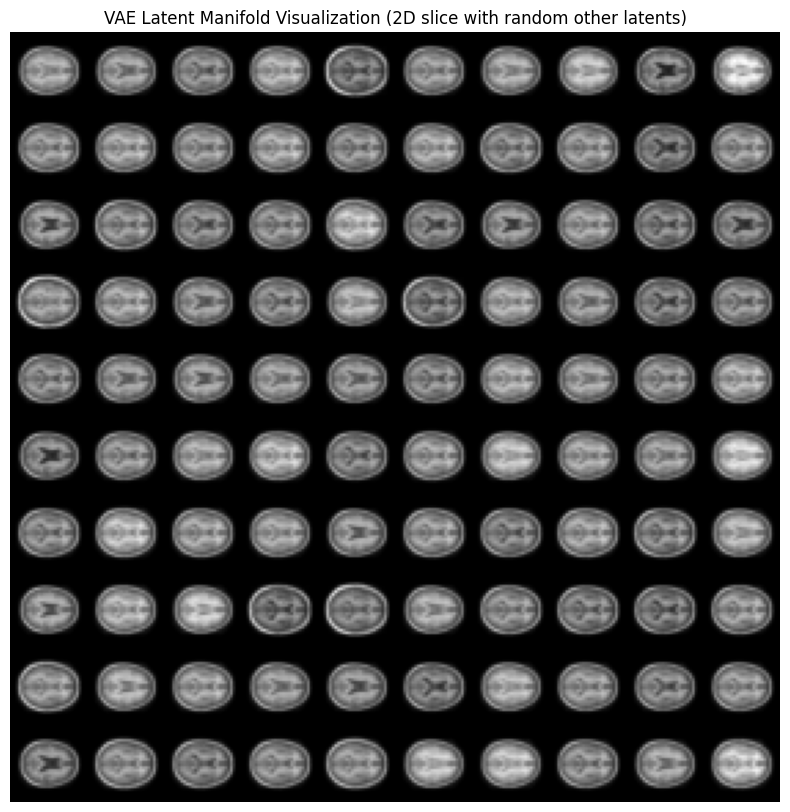

Generating latent space visualization using UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


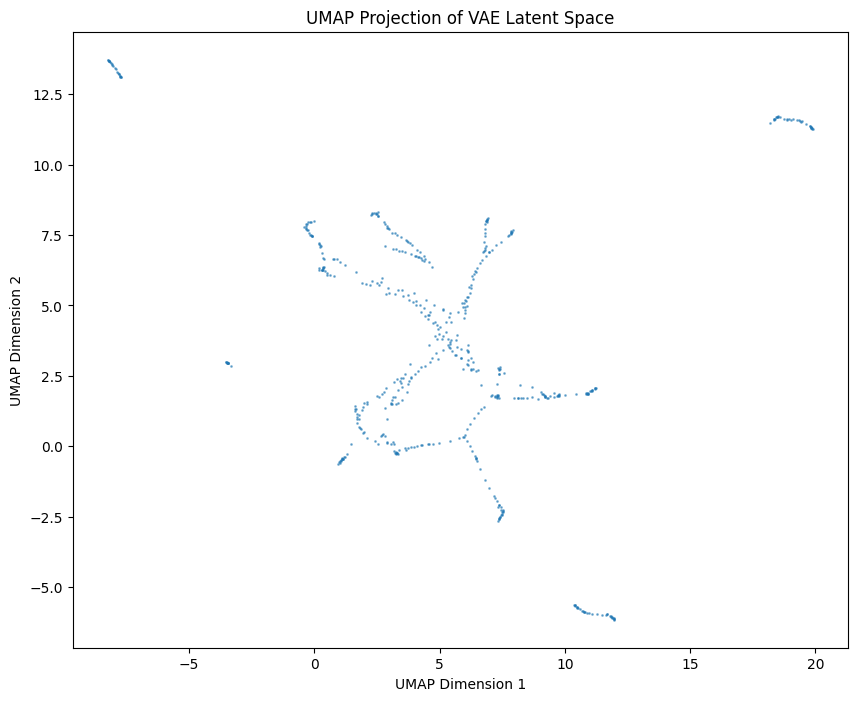

In [ ]:
# --- Latent Manifold Visualization (Sampling with Randomized Latents) ---
model.eval()
print("Generating latent space visualization by sampling with random background latents...")

# Create a 2D sampling grid from two latent dimensions
n = 10  # Number of images per row/column
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

figure = np.zeros((28 * n, 28 * n))
latent_dim = 32

# Choose which two latent dims to visualize
dim1, dim2 = 0, 1

with torch.no_grad():
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # Sample a random latent vector from N(0, I)
            z = torch.randn(1, latent_dim).to(device)

            # Override the two dimensions we want to visualize
            z[0, dim1] = xi
            z[0, dim2] = yi

            reconstruction = model.decode(z).cpu()

            # Handle decoder output shape safely
            img = reconstruction.squeeze().numpy()
            if img.ndim == 3:  # e.g. (C, H, W)
                img = img[0]  # take first channel if grayscale

            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.title('VAE Latent Manifold Visualization (2D slice with random other latents)')
plt.axis('off')
plt.savefig('vae_manifold_sampling_random.png')
plt.show()

# --- Latent Manifold Visualization (UMAP) ---
print("Generating latent space visualization using UMAP...")

# Load test dataset
test_dataset = OASISDataset(root_dir=test_dir, transform=transformations)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Collect latent vectors
latents = []
model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        mu, _ = model.encode(data)  # encode returns (mu, logvar)
        latents.append(mu.cpu().numpy())

# Stack all latent vectors
latents = np.concatenate(latents, axis=0)

# Standardize before UMAP
latents = StandardScaler().fit_transform(latents)

# Reduce dimensionality to 2 with UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(latents)

# Plot the embedding
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=1, alpha=0.5)
plt.title("UMAP Projection of VAE Latent Space")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.savefig("vae_manifold_umap.png")
plt.show()


# 4.2 UNET

In [6]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Cell 1: Setup, Imports, and Google Drive Mounting

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle



print("✅ Setup Complete. TensorFlow Version:", tf.__version__)

✅ Setup Complete. TensorFlow Version: 2.19.0


In [8]:
# Cell 1.5: Copy and Extract Data Locally

print("🚀 Copying data from Drive to local Colab runtime...")
# This single copy is MUCH faster than thousands of small reads
!cp /content/drive/MyDrive/OASIS/OASIS_png.zip /content/

print("✅ Copy complete. Extracting files...")
# Extracting on the local disk is lightning fast
!unzip -q /content/OASIS_png.zip -d /content/

print("✅ Extraction complete. Data is now ready on the local disk!")

🚀 Copying data from Drive to local Colab runtime...
✅ Copy complete. Extracting files...
✅ Extraction complete. Data is now ready on the local disk!


In [9]:
# Cell 2: Configuration and Data Loading

# --- Configuration ---
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1 # The MRI scans are grayscale
NUM_CLASSES = 4 # 0: Background, 1: CSF, 2: Gray Matter, 3: White Matter

# --- Paths to Dataset in Google Drive ---
# IMPORTANT: Make sure this base_path points to your OASIS folder
base_path = '/content/'

train_img_dir = os.path.join(base_path, 'keras_png_slices_train')
train_mask_dir = os.path.join(base_path, 'keras_png_slices_seg_train')
val_img_dir = os.path.join(base_path, 'keras_png_slices_validate')
val_mask_dir = os.path.join(base_path, 'keras_png_slices_seg_validate')
test_img_dir = os.path.join(base_path, 'keras_png_slices_test')
test_mask_dir = os.path.join(base_path, 'keras_png_slices_seg_test')


def load_and_preprocess_data(image_dir, mask_dir, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Loads images and masks, remaps mask values, normalizes images,
    resizes them, and one-hot encodes masks.
    """
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

    images = []
    masks = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        # Load and resize image
        img = Image.open(img_path).convert('L')
        img = img.resize(target_size)
        images.append(np.array(img))

        # Load and resize mask
        mask = Image.open(mask_path).convert('L')
        mask = mask.resize(target_size, resample=Image.NEAREST)
        mask_np = np.array(mask)

        # --- THIS IS THE FIX ---
        # Remap the pixel values from [0, 85, 170, 255] to [0, 1, 2, 3]
        mask_np[mask_np == 85] = 1
        mask_np[mask_np == 170] = 2
        mask_np[mask_np == 255] = 3
        # ----------------------

        masks.append(mask_np)

    # Convert to numpy arrays and normalize images
    images_np = np.array(images) / 255.0
    masks_np = np.array(masks)

    # Add channel dimension for grayscale images
    images_np = np.expand_dims(images_np, axis=-1)

    # One-hot encode the masks as required
    masks_cat = to_categorical(masks_np, num_classes=NUM_CLASSES)

    return images_np, masks_cat

# Load all datasets
print("⏳ Loading training data...")
X_train, y_train = load_and_preprocess_data(train_img_dir, train_mask_dir)
print(f"✅ Training data loaded. Images shape: {X_train.shape}, Masks shape: {y_train.shape}")

print("\n⏳ Loading validation data...")
X_val, y_val = load_and_preprocess_data(val_img_dir, val_mask_dir)
print(f"✅ Validation data loaded. Images shape: {X_val.shape}, Masks shape: {y_val.shape}")

print("\n⏳ Loading test data...")
X_test, y_test = load_and_preprocess_data(test_img_dir, test_mask_dir)
print(f"✅ Test data loaded. Images shape: {X_test.shape}, Masks shape: {y_test.shape}")

⏳ Loading training data...
✅ Training data loaded. Images shape: (9664, 256, 256, 1), Masks shape: (9664, 256, 256, 4)

⏳ Loading validation data...
✅ Validation data loaded. Images shape: (1120, 256, 256, 1), Masks shape: (1120, 256, 256, 4)

⏳ Loading test data...
✅ Test data loaded. Images shape: (544, 256, 256, 1), Masks shape: (544, 256, 256, 4)


In [11]:
# Cell 3: U-Net Model Architecture and Custom Metric

def dice_coef(y_true, y_pred, smooth=1e-6):
    """
    Calculates the Dice Similarity Coefficient for multi-class segmentation.
    Excludes the background class (class 0) from the calculation.
    """
    # Flatten the tensors and skip the background class (channel 0)
    y_true_f = K.flatten(y_true[..., 1:])
    y_pred_f = K.flatten(y_pred[..., 1:])

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=NUM_CLASSES):
    """
    Builds the U-Net model architecture.
    """
    inputs = Input(input_shape)

    # -- Encoder (Downsampling Path) --
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # -- Bottleneck --
    b = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    b = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(b)

    # -- Decoder (Upsampling Path) with Skip Connections --
    u3 = UpSampling2D((2, 2))(b)
    u3 = concatenate([u3, c3])
    d3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u3)
    d3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(d3)

    u2 = UpSampling2D((2, 2))(d3)
    u2 = concatenate([u2, c2])
    d2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u2)
    d2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(d2)

    u1 = UpSampling2D((2, 2))(d2)
    u1 = concatenate([u1, c1])
    d1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u1)
    d1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(d1)

    # -- Output Layer --
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(d1)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])

    return model

# Build and summarize the model
model = build_unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 487,060 (1.86 MB)

 Trainable params: 487,060 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Cell 4: Training the Model

# --- Callbacks ---
# Save the best model based on validation Dice coefficient
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_brain_mri_unet.keras',
    monitor='val_dice_coef',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Stop training early if there's no improvement
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_dice_coef',
    patience=10, # Number of epochs with no improvement to wait
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# --- Train the model ---
print("\n🚀 Starting model training...")
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=50, # Set a higher number, EarlyStopping will handle it
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint, early_stopping],
    shuffle=True
)
print("✅ Model training finished.")


🚀 Starting model training...


NameError: name 'model' is not defined

In [ ]:
# Cell 5: Evaluation and Visualization

# --- Load the best model for evaluation ---
# Note: EarlyStopping with restore_best_weights=True already loaded the best weights into the 'model' object.
# If you were running this in a separate script, you'd load the saved file like this:
# model = tf.keras.models.load_model(
#     'best_brain_mri_unet.keras',
#     custom_objects={'dice_coef': dice_coef}
# )

print("\n📊 Evaluating model on the test set...")
test_loss, test_dsc = model.evaluate(X_test, y_test, verbose=1)
print(f"\n🎉 Test Set Dice Similarity Coefficient (DSC): {test_dsc:.4f}")
print(f"📉 Test Set Loss: {test_loss:.4f}")

# --- Visualization of Results ---
def visualize_segmentation(model, images, true_masks, num_samples=5):
    """
    Visualizes the original image, true mask, and predicted mask for a few samples.
    """
    # Get predictions from the model
    predictions = model.predict(images)

    # Convert one-hot encoded data back to single-channel label maps for visualization
    true_labels = np.argmax(true_masks, axis=-1)
    predicted_labels = np.argmax(predictions, axis=-1)

    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        # Original Image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.title("Original MRI Slice")
        plt.imshow(images[i, :, :, 0], cmap='gray')
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.title("Ground Truth Segmentation")
        plt.imshow(true_labels[i], cmap='viridis')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.title(f"Predicted Segmentation")
        plt.imshow(predicted_labels[i], cmap='viridis')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Select a few random samples from the test set to visualize
sample_indices = np.random.choice(len(X_test), size=5, replace=False)

print("\n🖼️ Displaying segmentation results for 5 random test images...")
visualize_segmentation(
    model,
    X_test[sample_indices],
    y_test[sample_indices]
)

# 4.3 GAN

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import os
import zipfile

In [ ]:
# Define the path to your zip file in Google Drive
zip_path = '/content/drive/My Drive/OASIS/OASIS_png.zip'
extract_path = '/content/oasis_data'

# Create a directory to extract the files
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Unzip the dataset
print("Unzipping OASIS dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Dataset successfully unzipped.")

# The path to the training images
# We will use the 'keras_png_slices_train' folder
data_root = os.path.join(extract_path, 'keras_png_slices_train')
print(f"Training data will be loaded from: {data_root}")

Unzipping OASIS dataset...
Dataset successfully unzipped.
Training data will be loaded from: /content/oasis_data/keras_png_slices_train


In [ ]:
# Set device to GPU if available, otherwise CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Hyperparameters
Z_DIM = 100          # Size of the latent noise vector
IMG_SIZE = 64        # Images will be resized to 64x64
IMG_CHANNELS = 1     # The OASIS images are grayscale
BATCH_SIZE = 128
LR = 0.0002          # Learning rate, as suggested in the DCGAN paper
BETA1 = 0.5          # Adam optimizer's beta1 parameter
N_EPOCHS = 100       # Number of training epochs

# Create directory to save generated images
sample_dir = 'generated_images'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Using device: cuda


In [ ]:
import os
import glob
import shutil

# The path where your images are currently located
original_data_path = '/content/oasis_data/keras_png_slices_train'

# The name for our new "class" subfolder
class_folder_name = 'brain_scans'
class_folder_path = os.path.join(original_data_path, class_folder_name)

# Create the subfolder if it doesn't exist
if not os.path.exists(class_folder_path):
    os.makedirs(class_folder_path)
    print(f"Created subfolder: {class_folder_path}")

# Find all png images in the original path
image_files = glob.glob(os.path.join(original_data_path, '*.png'))

# Move each image into the new subfolder
for file_path in image_files:
    shutil.move(file_path, class_folder_path)

print(f"Moved {len(image_files)} images into the subfolder.")

# IMPORTANT: Update the data_root variable to point to the directory
# that CONTAINS the class folder.
data_root = original_data_path

Created subfolder: /content/oasis_data/keras_png_slices_train/brain_scans
Moved 9664 images into the subfolder.


In [ ]:
# Image transformations
# We resize the images and normalize them to be between -1 and 1
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # Normalizes to [-1, 1]
])

# Create the dataset and dataloader
dataset = datasets.ImageFolder(root=data_root, transform=transform)
data_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Custom weight initialization as suggested in the DCGAN paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: Z_DIM noise vector
            # Project and reshape
            nn.ConvTranspose2d(Z_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, IMG_CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
            # final state size. IMG_CHANNELS x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: IMG_CHANNELS x 64 x 64
            nn.Conv2d(IMG_CHANNELS, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Output: a probability
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator and discriminator
netG = Generator().to(DEVICE)
netD = Discriminator().to(DEVICE)

# Apply the weights_init function to randomly initialize all weights
netG.apply(weights_init)
netD.apply(weights_init)

# Print the models to see the architecture
print("Generator Architecture:")
print(netG)
print("\nDiscriminator Architecture:")
print(netD)

# Loss and Optimizers
criterion = nn.BCELoss()

# We create a fixed noise vector to see how the generator improves over time
fixed_noise = torch.randn(64, Z_DIM, 1, 1, device=DEVICE)

# Labels for real and fake images
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(BETA1, 0.999))

Generator Architecture:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

In [ ]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(N_EPOCHS):
    for i, data in enumerate(data_loader, 0):
        ## Train Discriminator ##
        # Maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()

        # Format batch
        real_cpu = data[0].to(DEVICE)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=DEVICE)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Generate fake image batch with G
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=DEVICE)
        fake = netG(noise)
        label.fill_(fake_label)

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ## Train Generator ##
        # Maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, N_EPOCHS, i, len(data_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

    # After each epoch, save a grid of generated images from our fixed_noise vector
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(make_grid(fake, padding=2, normalize=True)) # <-- ADD THIS LINE
    save_image(img_list[-1], f"{sample_dir}/epoch_{epoch+1}.png")

print("Training finished.")

Starting Training Loop...
[1/100][0/76]	Loss_D: 0.2147	Loss_G: 3.1261	D(x): 0.8490	D(G(z)): 0.0337 / 0.0641
[2/100][0/76]	Loss_D: 0.1091	Loss_G: 4.3687	D(x): 0.9095	D(G(z)): 0.0090 / 0.0197
[3/100][0/76]	Loss_D: 0.0627	Loss_G: 3.8517	D(x): 0.9785	D(G(z)): 0.0392 / 0.0299
[4/100][0/76]	Loss_D: 0.0748	Loss_G: 4.8888	D(x): 0.9630	D(G(z)): 0.0350 / 0.0118
[5/100][0/76]	Loss_D: 0.0720	Loss_G: 5.0405	D(x): 0.9862	D(G(z)): 0.0529 / 0.0097
[6/100][0/76]	Loss_D: 0.0776	Loss_G: 4.1574	D(x): 0.9433	D(G(z)): 0.0171 / 0.0260
[7/100][0/76]	Loss_D: 0.0768	Loss_G: 4.6558	D(x): 0.9637	D(G(z)): 0.0372 / 0.0154
[8/100][0/76]	Loss_D: 0.0588	Loss_G: 5.6456	D(x): 0.9507	D(G(z)): 0.0072 / 0.0059
[9/100][0/76]	Loss_D: 0.0612	Loss_G: 5.0674	D(x): 0.9864	D(G(z)): 0.0445 / 0.0093
[10/100][0/76]	Loss_D: 0.3090	Loss_G: 3.4217	D(x): 0.9125	D(G(z)): 0.1729 / 0.0503
[11/100][0/76]	Loss_D: 0.4186	Loss_G: 5.5563	D(x): 0.9652	D(G(z)): 0.2563 / 0.0070
[12/100][0/76]	Loss_D: 0.1254	Loss_G: 5.1894	D(x): 0.9785	D(G(z)): 0.0

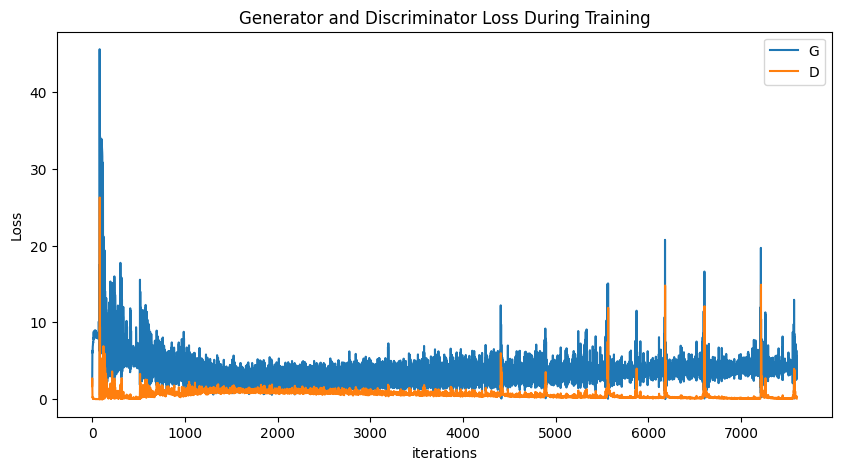

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

IndexError: list index out of range

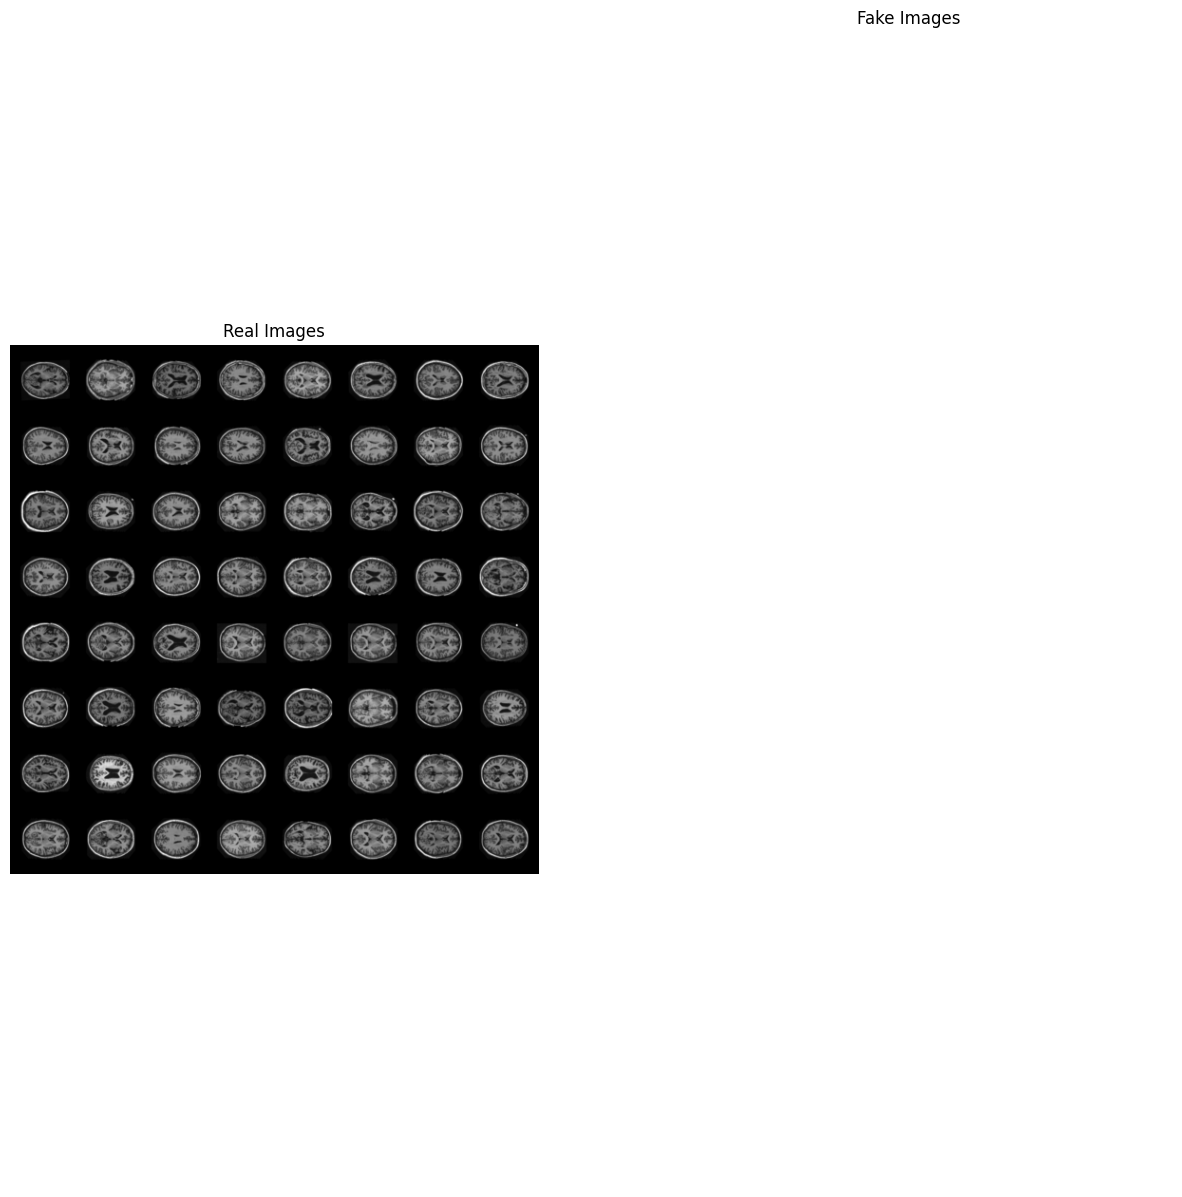

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Grab a batch of real images from the dataloader
real_batch = next(iter(data_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(DEVICE)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# To see a specific generated image from the last epoch:
img_file = f"{sample_dir}/epoch_{N_EPOCHS}.png"
if os.path.exists(img_file):
    from IPython.display import Image
    print(f"Generated images from the final epoch ({N_EPOCHS}):")
    display(Image(filename=img_file))
else:
    print("Could not find the final generated image file.")